# Checkpoint 1

**Due: Friday, 16 October, 2020 at 5:00pm BST**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

## Libraries and Constants
Custom imports and constants should be added to a new cell.

In [1]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline
import numpy as np
from scipy import integrate, optimize
import time

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Gravitational constant
gg     = 6.67408e-11 # m^3 s^-1 kg^-2
# Lunar mass
mass   = 7.342e22 # kg
# Lunar radius
radius = 1738000 # m
# 1 day in seconds
day    = 3600*24 # seconds

### Initial positions and velocities at t=0
rs = [1842280, 0] # m
vs = [0, 1634]    # m/s

## Equations of motion for the unperturbed case:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
\end{align}
$

# Task 1 (30p)

In the cell below, write a function that computes the trajectory from t = 0 to tmax, where tmax is given as an argument to the function. The function should return two arrays for the x and y positions of the trajectory. Each array should have N points (equally spaced in time), where N is given as an argument to the function. You may create additional cells for defining functions.

In [2]:
from scipy.integrate import solve_ivp
def task1(N, tmax):
    """
    Compute orbital trajectory.
    
    Parameters
    ----------
    N : int
        Number of points in trajectory arrays
    tmax : float
        End time of integration in units of seconds.
        
    Returns
    -------
    x : array
        x positions of the trajectory
    y : array
        y positions of the trajectory
    """
    
    # initial radius and velocity conditions as a single array
    fi = np.array([1842280,0,0, 1634])
    #Array of N timesteps equally spaced
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    
    # using solve_ivp to solve system of equations with set initial values and return two arrays
    #for x and y positions in the orbit
    sol = solve_ivp(differential, trange, fi,t_eval=time, dense_output=True, method ='Radau')
    
    return sol.y[0], sol.y[1]




    

In [3]:
""" 
function for solve ivp to differentiate system of equations 
"""
def differential(t,f):
    
    """
    f0 = x  => dx/dt  = vx
    f1 = y  => dy/dt  = vy
    f2 = vx => dvx/dt = - Gmx/ (x^2 + y^2)^(3/2)
    f3 = vy => dvy/dt = - Gmy/ (x^2 + y^2)^(3/2)
    """
    
    vals = np.zeros_like(f)
    vals[0] = f[2]
    vals[1] = f[3]
    vals[2] = - (gg *mass*f[0]) / ((f[0])**2+(f[1])**2)**(3/2)
    vals[3] = - (gg *mass*f[1]) / ((f[0])**2+(f[1])**2)**(3/2)

    return vals

##### Testing task 1

The cell below will run your function with inputs of tmax = 1 day (in seconds) and some number of points. The assert statements below will test that the returned arrays are the correct size.

In [4]:
t_max = day
n_points = int(t_max / 100)

x_pos, y_pos = task1(n_points, t_max)

assert x_pos.size == n_points
assert y_pos.size == n_points

# Task 1 continued

In the cell below, create an animation of the spacecraft's trajectory for t = 0 to 24 hours that includes a circle representing the Moon. Each frame of the animation should only show the last few points to avoid overlapping a previous orbit. A successful animation will be worth the full 30 points. Alternatively, create a static plot showing the Moon and the spacecraft's trajectory. This will be worth a maximum of 25 points.

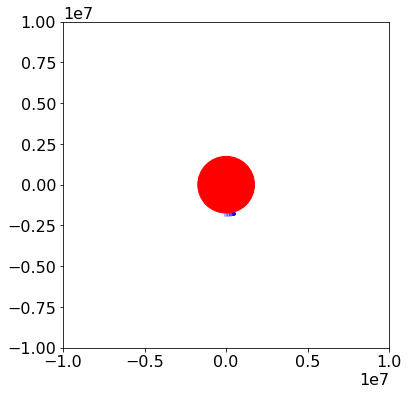

In [5]:
fig, ax = plt.subplots()
ax.axis('scaled')
ax.set_xlim(-1e7, 1e7)
ax.set_ylim(-1e7, 1e7)

#patch added for the static moon 
patch_1 = plt.Circle((0, 0), 1.738*10**6, color='red', alpha=1)
#list to store patches for the satellite's current position and its three previous positions.
patches = [0,0,0,0]

#loop to add the positions of orbit during the animation. 
#The alpha parameter is used to set the previous position points to a less opaque colour 
for j in range(0,4):  
    patches[j] = plt.Circle((1842280,0),10**5, color='blue', alpha=1/(j+1))    
    ax.add_patch(patches[j])
    
ax.add_patch(patch_1)






# animation function. This will be call in a sequence to generate frames.
def animate(i):
    for j in range(0,4):
        # the starting positions of the orbit trail(previous points) set to the same place as the satellite
        if i-j < 0: 
            patches[j].center = (x_pos[i],y_pos[i]) 
        else:
            patches[j].center = (x_pos[i-j],y_pos[i-j]) #previous positions patches will startrt orbiting at a delayed time step
    
    return (patches)

#setting this to equal the number of of time steps would show the full solution, one full lunar period, however due to memory issues I have set frames to 200.
frames = 200 
anim = animation.FuncAnimation(fig, animate, frames= frames, interval=20, repeat=False)

HTML(anim.to_jshtml())



# Task 2 (15p)

Determine the orbital period T. Your solution must be calculated numerically, i.e., not simply using the analytical expression. The obtained value must be within +/-1 s of the correct value.

In the cell below, write a function that returns the orbital period in units of seconds.

In [7]:
def task2():
    k=0
    x_pos,y_pos = task1(86400,86400)

    for k in range(len(y_pos)):   
        if y_pos[k] < 0:
            break                 #loop breaks just after half an orbital period; y coordinate first drops below y = 0
        else:
            k += 1
    
    k1 = k
    #k2 is the step just before half an orbital period
    k2 = k-1
    y_k1 = y_pos[k1]
    y_k2 = y_pos[k2]                             
    
    #ratio of y_pos values above and below y= 0 and the corresponding time step values to find time(in steps) when y=0
    t_root = k2 - y_k2*(k2-k1)/(y_k2 - y_k1)                           
    t_rootsec = t_root  
    
    #need to multiply by 2 to get period
    period = t_rootsec*2                          

    
    return period    
    
task2()
        




   

7138.231540848539

## Testing task 2

The cell below will run your function and compare with the analytic answer. They should agree to within 1 second.

In [8]:
T_calc = task2()
t1 = time.time()
print (f"Calculated orbital period: {T_calc} seconds.")
t2 = time.time()

mu = gg * mass
T_analytic = 2 * np.pi * np.sqrt((rs[0]**3 * mu**2) / (2*mu - rs[0]*vs[1]**2)**3)

print (f"Difference with correct answer: {T_calc - T_analytic} seconds.")
print (f"Solution calculated in {t2-t1} seconds.")

assert abs(T_calc - T_analytic) <= 1

print ("Hooray!")

Calculated orbital period: 7138.231540848539 seconds.
Difference with correct answer: -0.1678839397500269 seconds.
Solution calculated in 0.00021839141845703125 seconds.
Hooray!


# Task 3 (20p)

Now add a correction that makes the gravitational field non-spherical. The correction rotates with the Moon (one full rotation every T$_{Moon}$ = 27.3 days). How long does it take until the spacecraft hits the Moon? The time must be accurate to +/-1 s. Assume the Moon’s surface is a sphere. The equations of motion now become:

$
\Large
\begin{align}
\frac{d^{2} x}{dt^2} = - \frac{G M x}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M x^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
\frac{d^{2} y}{dt^2} = - \frac{G M y}{(x^2 + y^2)^{3/2}}
- \frac{q\ G M y^\prime}{(x^{^\prime2} + y^{^\prime2})^{3/2}}
\end{align}
$

$
\Large
\begin{align}
x^\prime = x + 0.8\ R \cos \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

$
\Large
\begin{align}
y^\prime = y + 0.8\ R \sin \left( \frac{2 \pi t}{T_{Moon}} \right)
\end{align}
$

where q = 0.00025.

## Task 3 objectives:
1. Compute the time at which the spacecraft hits the Moon.
2. Make a plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

# Task 3 part 1

In the cell below, create a function that returns the impact time accurate to within 1 second.

In [9]:
def task3():
    fi = np.array([1842280,0,0, 1634])
    tmax= 86400 *10
    N = 86400 *10
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    q = 0.00025
    args = (q,)
    

    sol = solve_ivp(differential1, trange, fi,t_eval=time, args = args, max_step = 50)
    x_pos, y_pos =  sol.y[0], sol.y[1]
      
   
    
    z = 0
    #calculating radius of satellite orbit
    r_sat = (x_pos[z]**2 + y_pos[z]**2)**(1/2)   
    
    #while loop calculates new values for satellite orbital radius until it is smaller than the lunar radius (at which pint the satellite has crashed)
    while r_sat > radius:     
        r_sat = (x_pos[z]**2 + y_pos[z]**2)**(1/2)
        z += 1
    return z

    
"""
This differential1 function is similar to the first one. However it now passes q as an argument. This is then used in the 
term subtracted from  - Gmx/ (x^2 + y^2)^(3/2) and - Gmy/ (x^2 + y^2)^(3/2). The q represents the amplitude of perturbation.
""" 

def differential1(t,f,q):
    T_moon = 27.3 *24 * 60*60
    
    """
    f0 = x  => dx/dt  = 𝑥+ 0.8 𝑅cos(2𝜋𝑡/𝑇𝑀𝑜𝑜𝑛) 
    f1 = y  => dy/dt  = 𝑦+ 0.8 𝑅sin(2𝜋𝑡/𝑇𝑀𝑜𝑜𝑛)
    f2 = vx => dvx/dt = - Gmx/ (x^2 + y^2)^(3/2) - 𝑞 𝐺𝑀𝑥′/(𝑥′^2+𝑦′^2)^(3/2)
    f3 = vy => dvy/dt = - Gmy/ (x^2 + y^2)^(3/2) - 𝑞 𝐺𝑀y′/(𝑥′^2+𝑦′^2)^(3/2)
    """
    vxc = f[0] + 0.8 * radius * np.cos((2*np.pi*t/T_moon)) 
    vyc = f[1] + 0.8 * radius * np.sin((2*np.pi*t/T_moon)) #x' and y' corrections 
    vals = np.zeros_like(f)
    vals[0] = f[2] 
    vals[1] = f[3] 
    vals[2] = - ((gg *mass*f[0]) / ((f[0])**2+(f[1])**2)**(3/2)) - q*gg*mass*vxc/(vxc**2 + vyc**2)**(3/2)
    vals[3] = - ((gg *mass*f[1]) / ((f[0])**2+(f[1])**2)**(3/2)) - q*gg*mass*vyc/(vxc**2 + vyc**2)**(3/2)
    
    return vals



## Testing task 3 part 1

The cell below will run your function and print your answer. This will be tested against the correct answer (not given).

In [10]:
t1 = time.time()
t_impact = task3()
t2 = time.time()

print (f"Time to impact: {t_impact:.2f} seconds ({t_impact / day:.2f} days).")
print (f"Solution calculated in {t2-t1} seconds.")

Time to impact: 627065.00 seconds (7.26 days).
Solution calculated in 6.825235843658447 seconds.


## Task 3 part 2

In the cell below, plot of the height of the spacecraft above the Moon's surface as a function of time. Don't forget to label axes and include units.

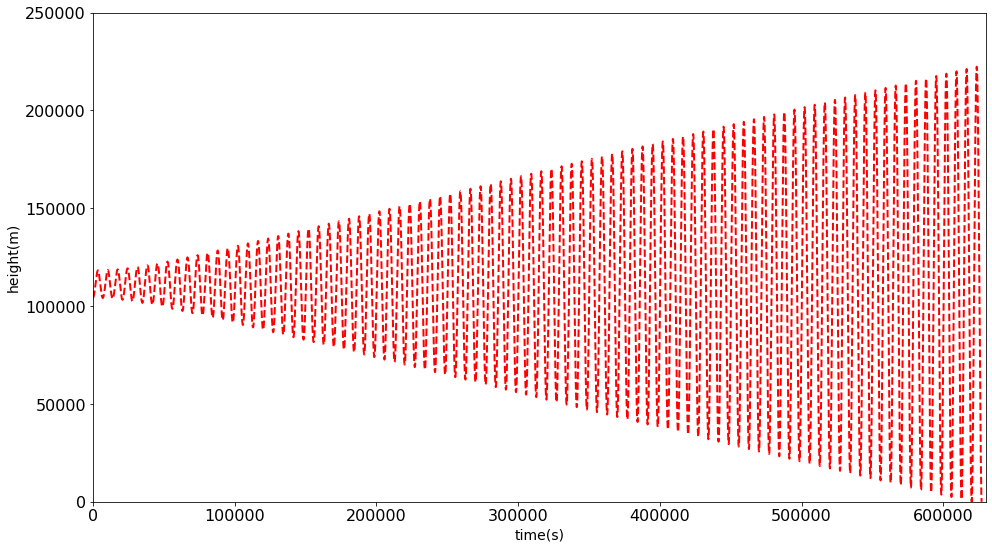

In [11]:
def sat_height():
    fi = np.array([1842280,0,0, 1634])
    tmax =  86400*10
    N = 86400*10
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    q = 0.00025
    args = (q,)


    sol = solve_ivp(differential1, trange, fi,t_eval=time, args = args, max_step = 100)
    x_pos, y_pos =  sol.y[0], sol.y[1]

    z = 0

    r_sat = (x_pos[z]**2 + y_pos[z]**2)**(1/2)
    #create empty list to store values for the height of the satellite
    height= [] 
    
    for z in range(tmax):
        z += 1
        r_sat = (x_pos[z]**2 + y_pos[z]**2)**(1/2)
                                              
        #height is calculated from the radius of the satellite minus the lunar radius
        height.append(r_sat-radius)              
        if r_sat <= radius:
            break           #loop breaks if satellite radius is lower than the lunar radius, this is when the satellite crashes
    return height, time, z


def plot_height():
    
    fig, ax = plt.subplots(figsize=(16, 9))

    height, time, z = sat_height()

    ax.plot(time[:z], height, linestyle='--', linewidth=2, color='red')
    ax.xaxis.set_label_text('time(s)', fontsize=14)
    ax.yaxis.set_label_text('height(m)', fontsize=14)
    plt.xlim(0,630000)
    plt.ylim(0,250000)

    plt.show()
    
plot_height()

    


# Task 4 (10p)

Which coordinate (x or y) of the position of the spacecraft after one revolution (orbital period T from task 2) is more sensitive to small changes in the amplitude of the correction? To answer this, calculate the derivatives of dx/dq and dy/dq at t = T, for q = 0. Write your answer in the cell below, describing how you arrived at it. Place any code that demonstrates your solution in the cell with the function called `task4`.

YOUR ANSWER HERE

In [12]:
""" 
y coordinate is more sensitive than the y x-coordinate to small changes in the amplitude of the correction. This was
calculated by using the Euler approximation to approximate the derivative of y with respect to q and the derivitve of x with
respect to q to show that the change in y when q is changed is greater than the change in x when q is changed.

"""
def task4():
    period = task2()
    tmax = period
    N = 7138
    fi = np.array([1842280,0,0, 1634])
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    
    #changing perturbation around q = 0
    q1 = 0.00000002
    q2 = 0.00000000
    args1 = (q1,)
    args2 = (q2,)
    # perturbated solution
    p_sol = solve_ivp(differential1, trange, fi,t_eval=time, dense_output=True, args = args1 , max_step = 100)
    #non-perturbated solution
    np_sol = solve_ivp(differential1, trange, fi,t_eval=time, dense_output=True, args = args2 , max_step = 100)
    
    # sx = dx/dq and using euler approximation
    sx = (p_sol.y[0][-1]- np_sol.y[0][-1])/q1
    sy = (p_sol.y[1][-1] - np_sol.y[1][-1])/q1
    
    print(sx, sy)
    #using absolute values because the x and y coordinates can be negative during the orbit
    if abs(sy) > abs(sx):
        print('y coordinate is more sensitive to changes in amplitude of coorection')
        
    else:
        print('x coordinate is more sensitive to changes in amplitude of coorection')
    
task4()

-43810.91566756368 32065762.66384218
y coordinate is more sensitive to changes in amplitude of coorection


# Task 5 (10p)

The positions of the spacecraft at t=0, t=T/2, and t=T are given in the cell below. Use them to determine the amplitude of the correction q. Note, this is a different value than for the previous tasks.

A comment for those interested in space science: this is a highly simplified and unrealistic version of the task NASA scientists had to carry out to map out the gravity at the Moon's surface using "telemetry" data (positions and velocities) of various spacecrafts orbiting the Moon.

Put your code in the cell that starts with `def task5():`.

Your answer should be within 20% of the correct answer.

In [13]:
r1 = [1842280.0, 0.0]
r2 = [-1856332.7223839264, -717.5195460640389]
r3 = [1842271.070055315, 3847.378923359429]

In [14]:
"""
condition function is repeatedly called and given an x or y coordinate at the period or half period of the satellite orbit
for a given q value, and then checks this coordinate against the corresponding correct coordinate r2[0], r2[1], r3[0] or r3[1].
If the given coordinate in sufficient range of the correct coordinate then the function returns true and the the next coordinate
to be checked is passed through.

""" 

def condition(value, correct_coord):
    uncertainty = 0.2                            #allowed error in the position values 
    lbound = correct_coord* (1 - uncertainty)
    ubound = correct_coord* (1 + uncertainty)
    if  abs(value) < abs(ubound) and abs(value) > abs(lbound) :        
        return True
    else:
        return False

def task5():
    tmax = task2()  #getting time period of orbit from task 2
    t_half = tmax/2    
    

    fi = np.array([1842280,0,0, 1634])
    time = [0,t_half, tmax]
      
    trange = (time[0],time[-1])
    
    #creating an array of q values. 
    q_array = np.linspace(0,0.0003,100)
    
    #create list to store values of q for which the the coordinates of the orbit at the half period and full period 
    #are similar to the positions of given, r2 and r3, within the allowed error
    q_list=[]
    
    #iterate through array of q values
    for q in q_array:
        args = (q,)   
        xy_position = solve_ivp(differential1,trange,fi,t_eval=time, args = args,max_step = 100)
        
        if condition(xy_position.y[0][1], r2[0]) is False:
            continue
        if condition(xy_position.y[1][1], r2[1]) is False:
            continue
        if condition(xy_position.y[0][2], r3[0]) is False: 
            continue
        if condition(xy_position.y[1][2], r3[1]) is False: 
            continue
        else:
            q_list.append(q)
    #calculating the mean of the q values in q_list to get the most accurate value of q.       
    q_av = np.sum(q_list)/len(q_list)
    return q_av
    
task5()


0.00013636363636363637

## Testing task 5

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 20% of the correct answer.

In [15]:
t1 = time.time()
mystery_q = task5()
t2 = time.time()

print (f"q = {mystery_q}")
print (f"Solution calculated in {t2-t1} seconds.")


q = 0.00013636363636363637
Solution calculated in 2.38265323638916 seconds.


# Task 6 (15p)

What is the minimum initial height of a circular orbit such that, for the perturbation from task 3 (q = 0.00025), the spacecraft does not collide with the Moon but remains gravitationally bound to it?

The orbit may still show oscillations as in task 3, but the spacecraft cannot not hit the lunar surface.

Create a function `task6` that returns the minimum height of the circular orbit in units of meters. Explain your approach. To obtain full marks, the answer must be correct to +/-1 km.

The following formula for the velocity of a point mass in circular orbit of radius r, orbiting a spherically symmetric body of mass M, may be useful:

$
\Large
\begin{align}
v_{c} = \sqrt{\frac{G\ M}{r}}.
\end{align}
$

In the cell below, create a function that calculates the minimum height of a stable orbit in units of meters. Your answer should be within 1000 meters of the correct answer.

In [16]:

"""
I use the brentq root finding method along with solve_ivp in order to find the minimum initial height. I put my initial root
finding bounds as 1842280 (where I know the satellite crashes from task 3), and 6000000. I run the simulation for a maximum
time of 30 days. I show that this is enough time with another set of functions below which plot a graph of height against 
time and show that every  ~ 26 days, the height plot repeats itself, which means the orbit is stable.

"""




    

'\nI use the brentq root finding method along with solve_ivp in order to find the minimum initial height. I put my initial root\nfinding bounds as 1842280 (where I know the satellite crashes from task 3), and 6000000. I run the simulation for a maximum\ntime of 30 days. I show that this is enough time with another set of functions below which plot a graph of height against \ntime and show that every  ~ 26 days, the height plot repeats itself, which means the orbit is stable.\n\n'

In [17]:
""" 
Function to calculate the initial velocity given the inital radius

"""

def init_vel(initial_radius):
    init_vsat = np.sqrt(gg*mass/initial_radius)
    
    return init_vsat


""" 
Function that calculates the minimum height of the satellite orbits in the given time value 

"""

def lowestheight(r_sat):
    tmax= 86400*30
    N = 86400
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    init_vsat = init_vel(r_sat)
    fi = np.array([r_sat,0, 0, init_vsat])  
    
    q = 0.00025
    args = (q,)
    
    solut = solve_ivp(differential1, trange, fi,t_eval=time, args = args, max_step = 100)
    r_sat = np.sqrt(solut.y[0]**2 + solut.y[1]**2) 
    
    h = r_sat - radius
    k = 0
    h_low = h[0]
    
    #iterate through all the height values to find the lowest height value and set that to h_low
    #which is then returned to root finder
    for k in range(N):
        if h[k] < h_low:
            h_low = h[k]
            k += 1
        else:
            k += 1
            continue
        
    return h_low

      
def task6():
         
    minim = 1842280
    maxim = 6000000
    
    #This runs the lowestheight function many times and takes the h_low values given parameters between minim and maxim.
    
    root = optimize.brentq(lowestheight, minim, maxim, rtol = 10e-6) 
   
    return (root)
  
    

    




    

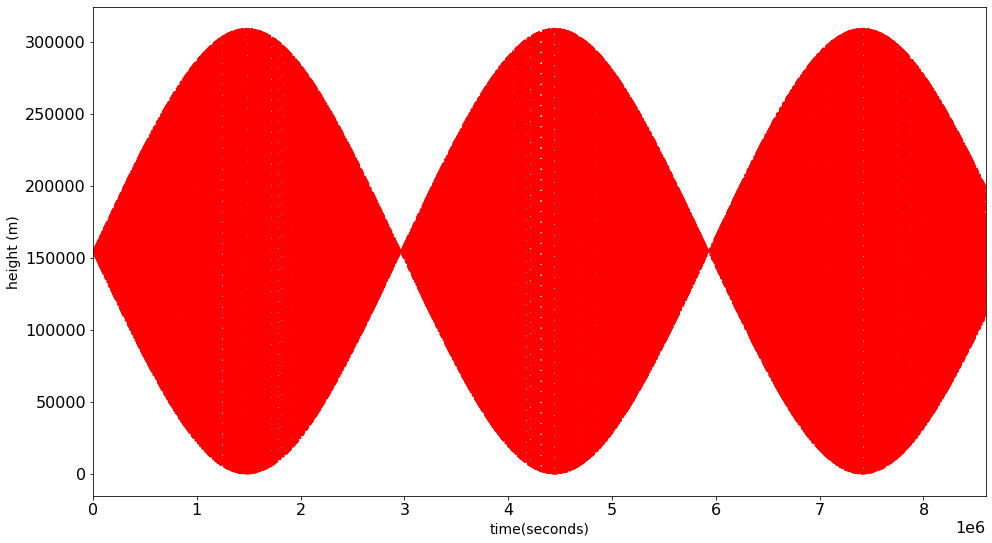

In [18]:
"""
Plot to show that at the minimum initial height, the orbit is stable.

"""

def sat_height2():
    r_sat = 1892607
    init_vsat = init_vel(r_sat)
    
    fi = np.array([r_sat,0, 0, init_vsat])  
    tmax =  86400 * 100
    N = 86400
    time = np.linspace(0,tmax,N)
    trange = (time[0],time[-1])
    q = 0.00025
    args = (q,)


    sol = solve_ivp(differential1, trange, fi,t_eval=time, args = args, max_step = 100)
    x_pos, y_pos =  sol.y[0], sol.y[1]

    z = 0

    height= []                             #create empty list to store values for the height of the satellite
    for z in range(N):
        
        r_sat = (x_pos[z]**2 + y_pos[z]**2)**(1/2)
        height.append(r_sat-radius) 
        z += 1
        if r_sat <= radius:
            break
     
    return height, time, z


def plot_height2():
    
    fig, ax = plt.subplots(figsize=(16, 9))

    height, time, z = sat_height2()

    ax.plot(time[:z], height, linestyle='--', linewidth=2, color='red')
    ax.xaxis.set_label_text('time(seconds)', fontsize=14)
    ax.yaxis.set_label_text('height (m)', fontsize=14)
    plt.xlim(0,8.6e6)
  

    plt.show()
    
plot_height2()







## Testing task 6

The cell below will run your function and print your answer. This will be tested against the correct answer (not given). Your answer should be within 1000 meters of the correct answer.

In [ ]:
t1 = time.time()
min_height = task6()
t2 = time.time()
print (f"Minimum height of stable orbit: {min_height} m.")
print (f"Solution calculated in {t2-t1} seconds.")
